## Proof of Concept Workflow: Identifying potential candidates for data collection

Created: 9 November 2023<br>
Last modified: 13 may 2024<br>
Changes: Updated in lieu of new inventory, updates to ToxVal 9.5, and all monitoring sources and literatures hits within pubmed will have changed in the last year.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
df = pd.read_excel(interim_dir+'final_landscape_with_predicted_NAMs_130524.xlsx', index_col = [0] )


In [4]:
df.final_centroid.nunique()

128

In [5]:
universe_ids = df.dtxsid.tolist()

In [6]:
len(universe_ids)

15525

In [7]:
df.shape

(15525, 171)

In [8]:
toxval = pd.read_csv(raw_dir+'toxval95_all.csv', index_col = [0])

/tmp/ipykernel_364779/845230242.py:1: DtypeWarning: Columns (33,39) have mixed types. Specify dtype option on import or set low_memory=False.
  toxval = pd.read_csv(raw_dir+'toxval95_all.csv', index_col = [0])


In [11]:
toxval.toxval_units.value_counts()

mg/kg-day                        125427
mg/kg                             69549
mg/m3                             25598
mg/L                              12705
ppm                                2304
                                  ...  
g/kg-day                              1
uM/100 g                              1
nM/mol                                1
ug/kr/day                             1
mg narasin activity/kg bw/day         1
Name: toxval_units, Length: 258, dtype: int64

In [12]:
toxval.study_type.unique()

array(['reproduction developmental', 'chronic', 'developmental',
       'subchronic', 'reproduction', 'short-term', '28-day', 'acute',
       'uterotrophic', 'Hershberger', 'intermediate', 'in vitro',
       'toxicity test, other', 'ecotoxicity', 'repeat dose other',
       'endocrine disrupter mammalian screening - in vivo',
       'immunotoxicity', 'neurotoxicity', '-', 'human', 'clinical',
       'occupational', 'epidemiologic', 'toxicity value', 'genotoxicity',
       'special', 'subchronic-chronic'], dtype=object)

In [19]:
mask = (toxval['exposure_route'].isin( ['oral', 'inhalation']) & (toxval['qc_status'] == 'pass') & (toxval['toxval_type_supercategory'] =='Point of Departure') & \
(toxval['toxval_type'].isin(['NOAEL', 'NOEL', 'LEL', 'LOAEL', 'LOEL','HNEL', 'NEL',  'NOAEC', 'LOAEC'])) & \
(toxval['species_id'].isin([4491,4500,4501,4510,4511,4516,4520,4901,4913,4928,4988,5557,7630,7632,11193,17317,19568,20657,21216,22808])) &\
(toxval['study_type'].isin(['chronic', 'subchronic', 'reproduction developmental', 'developmental', 'short-term', 'reproduction', '28-day','repeat dose other','immunotoxicity', 'neurotoxicity'])) &\
(toxval['toxval_units'].isin(['mg/kg', 'mg/kg-day', 'mg/m3', 'mg/L', 'ppm', 'ppb'])))


In [20]:
toxval.study_type.unique()

array(['reproduction developmental', 'chronic', 'developmental',
       'subchronic', 'reproduction', 'short-term', '28-day', 'acute',
       'uterotrophic', 'Hershberger', 'intermediate', 'in vitro',
       'toxicity test, other', 'ecotoxicity', 'repeat dose other',
       'endocrine disrupter mammalian screening - in vivo',
       'immunotoxicity', 'neurotoxicity', '-', 'human', 'clinical',
       'occupational', 'epidemiologic', 'toxicity value', 'genotoxicity',
       'special', 'subchronic-chronic'], dtype=object)

In [21]:
txval = toxval[mask]

In [22]:
txval.shape

(99080, 45)

In [23]:
universe_tox = df[df['dtxsid'].isin(txval.dtxsid.tolist())]

In [24]:
analogue_df = txval[txval['dtxsid'].isin(df.dtxsid.unique())]

In [25]:
analogue_df.toxval_type.unique()

array(['NOAEL', 'LOAEL', 'LEL', 'NEL', 'NOEL', 'LOEL', 'LOAEC', 'NOAEC',
       'HNEL'], dtype=object)

In [26]:
df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'Substance_Note', 'smiles', 'Structure_InChI',
       'Structure_InChIKey', 'Structure_Formula',
       ...
       'pred_DNT', 'pred_Immune', 'pred_NR_ESR1', 'pred_NR_NRF2',
       'pred_NR_PPAR', 'pred_NR_PXR', 'pred_No flag', 'pred_TK_PlasBind',
       'pred_ZF', 'pred_TK'],
      dtype='object', length=171)

In [27]:
landscape_dict = {k:v for k,v in zip(df['dtxsid'], df['group_str'])}

In [28]:
analogue_df['group_str'] = analogue_df['dtxsid'].replace(landscape_dict)

/tmp/ipykernel_364779/3439423276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analogue_df['group_str'] = analogue_df['dtxsid'].replace(landscape_dict)


In [29]:
iv_tox = analogue_df.groupby(['dtxsid', 'study_type']).size().reset_index().pivot_table(index = 'dtxsid', columns = 'study_type', values = 0)

In [30]:
iv_tox.columns.name = None

<Axes: ylabel='dtxsid'>

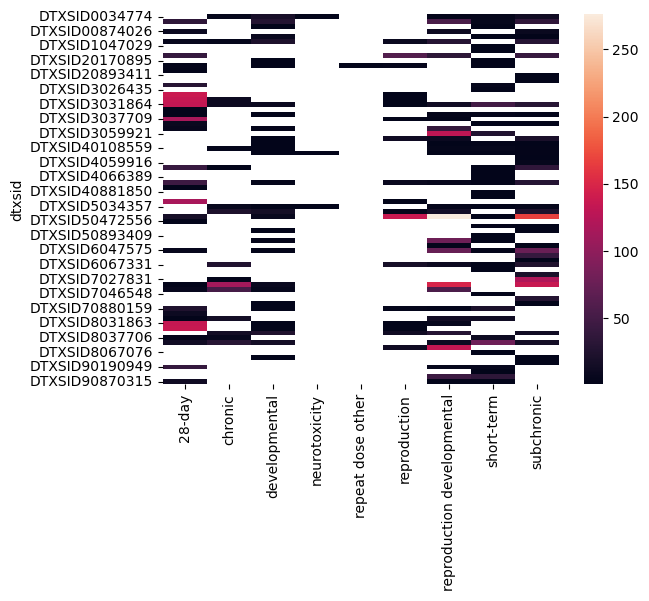

In [31]:
sns.heatmap(iv_tox)

In [32]:
iv_tox_v1 = iv_tox.applymap(lambda x: 1 if pd.notnull([x]) else np.nan )

In [136]:
iv_tox_v1

,28-day,chronic,developmental,neurotoxicity,repeat dose other,reproduction,reproduction developmental,short-term,subchronic
dtxsid,,,,,,,,,
DTXSID0034774,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0
DTXSID0061826,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0
DTXSID0067848,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN
DTXSID00874026,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
DTXSID1024251,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...
DTXSID80889254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
DTXSID90190949,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
DTXSID9027150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


Lists

In [137]:
import glob

In [138]:
files = glob.glob(external_dir+'/*mapped_070424.xlsx', 
                   recursive = True)
for file in files:
    print(file)

/home/grace/Documents/python/nts_pfas/data/external/tri_waste_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/tri_onsite_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/drinking_water_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/discharge_monitoring_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/tri_offsite_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/environmental_media_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/drinking_water_ucmr_mapped_070424.xlsx
/home/grace/Documents/python/nts_pfas/data/external/production_data_mapped_070424.xlsx


In [139]:
def read_file(fs):
    mylst = []
    for f in fs:
        df = pd.read_excel(f)
        #df.drop(['Unnamed: 0'], axis = 1, inplace = True)
        df['source'] = f
        mylst.append(df)
        mydfs = pd.concat(mylst)
    return mydfs

In [140]:
lists = read_file(files)

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [141]:
lists['source'].unique()

array(['/home/grace/Documents/python/nts_pfas/data/external/tri_waste_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_onsite_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/discharge_monitoring_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_offsite_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/environmental_media_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_ucmr_mapped_070424.xlsx',
       '/home/grace/Documents/python/nts_pfas/data/external/production_data_mapped_070424.xlsx'],
      dtype=object)

In [142]:
source_dict = {'/home/grace/Documents/python/nts_pfas/data/external/tri_onsite_mapped_070424.xlsx' : 'TRI-ONSITE',
       '/home/grace/Documents/python/nts_pfas/data/external/production_data_mapped_070424.xlsx': 'PROD_DATA',
       '/home/grace/Documents/python/nts_pfas/data/external/discharge_monitoring_mapped_070424.xlsx': 'DISCHARGE',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_waste_mapped_070424.xlsx' : 'TRI_WASTE',
               '/home/grace/Documents/python/nts_pfas/data/external/environmental_media_mapped_070424.xlsx': 'ENV_MEDIA',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_ucmr_mapped_070424.xlsx' : 'DRINKING_WATER-UCMR',
       '/home/grace/Documents/python/nts_pfas/data/external/drinking_water_mapped_070424.xlsx' : 'DRINKING_WATER',
       '/home/grace/Documents/python/nts_pfas/data/external/tri_offsite_mapped_070424.xlsx' : 'TRI-OFFSITE'}

In [143]:
lists['source']  = lists['source'].replace(source_dict)

In [144]:
lists

,Query,Found_By,DSSTox_Substance_Id,DSSTox_Structure_Id,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,Structure_SMILES,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,Structure_SMILES_2D-QSAR,DateModified,source,FOUND_BY,IUPAC_NAME,Unnamed: 7
0,116-14-3,CAS-RN matched <b>null</b>,DTXSID6021325,DTXCID301325,DSSTox_High,Tetrafluoroethylene,116-14-3,Single Compound,NaN,FC(F)=C(F)F,"InChI=1S/C2F4/c3-1(4)2(5)6\nAuxInfo=1/0/N:3,4,...",BFKJFAAPBSQJPD-UHFFFAOYSA-N,C2F4,100.016,FC(F)=C(F)F,20230320.0,TRI_WASTE,NaN,NaN,NaN
1,375-73-5,CAS-RN matched <b>null</b>,DTXSID5030030,DTXCID3010030,DSSTox_High,Perfluorobutanesulfonic acid,375-73-5,Single Compound,NaN,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,"InChI=1S/C4HF9O3S/c5-1(6,3(9,10)11)2(7,8)4(12,...",JGTNAGYHADQMCM-UHFFFAOYSA-N,C4HF9O3S,300.090,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,20230721.0,TRI_WASTE,NaN,NaN,NaN
2,29420-49-3,CAS-RN matched <b>null</b>,DTXSID3037707,DTXCID1017707,DSSTox_High,Potassium perfluorobutanesulfonate,29420-49-3,Single Compound,Record was reviewed with Common Chemistry.,[K+].[O-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,"InChI=1S/C4HF9O3S.K/c5-1(6,3(9,10)11)2(7,8)4(1...",LVTHXRLARFLXNR-UHFFFAOYSA-M,C4F9KO3S,338.180,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,20231115.0,TRI_WASTE,NaN,NaN,NaN
3,76-14-2,CAS-RN matched <b>null</b>,DTXSID8026434,DTXCID906434,DSSTox_High,"1,2-Dichloro-1,1,2,2-tetrafluoroethane",76-14-2,Single Compound,NaN,FC(F)(Cl)C(F)(F)Cl,"InChI=1S/C2Cl2F4/c3-1(5,6)2(4,7)8\nAuxInfo=1/0...",DDMOUSALMHHKOS-UHFFFAOYSA-N,C2Cl2F4,170.920,FC(F)(Cl)C(F)(F)Cl,20210521.0,TRI_WASTE,NaN,NaN,NaN
4,2837-89-0,CAS-RN matched <b>null</b>,DTXSID7029245,DTXCID509245,DSSTox_High,"2-Chloro-1,1,1,2-tetrafluoroethane",2837-89-0,Single Compound,NaN,FC(Cl)C(F)(F)F,"InChI=1/C2HClF4/c3-1(4)2(5,6)7/h1H\nAuxInfo=1/...",BOUGCJDAQLKBQH-UHFFFAOYNA-N,C2HClF4,136.470,FC(Cl)C(F)(F)F,20170228.0,TRI_WASTE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,"Benzoic acid, 2,3,4,5-tetrachloro-6-[[[3-[[(he...",Name2Structure matched <b>null</b>,DTXSID80880488,DTXCID201021910,DSSTox_High,"Potassium 2,3,4,5-tetrachloro-6-(((3-(((heptad...",57589-85-2,Single Compound,Record was reviewed with Common Chemistry.\n,[K+].[H]N(C(=O)C1=C(C([O-])=O)C(Cl)=C(Cl)C(Cl)...,InChI=1S/C22H6Cl4F17NO6S.K/c23-9-7(8(14(46)47)...,HZRBKZMKUYGJRU-UHFFFAOYSA-M,C22H5Cl4F17KNO6S,915.210,OC(=O)C1=C(C(=O)NC2=CC(OS(=O)(=O)C(F)(F)C(F)(F...,20220818.0,PROD_DATA,NaN,NaN,NaN
75,"Propanyl fluoride, 2,3,3,3-tetrafluoro-2-(pent...",Not Found,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PROD_DATA,NaN,NaN,NaN
76,"Ethanesulfonyl fluoride, 2-[1-[difluoro[(trifl...",Valid Synonym matched <b>null</b>,DTXSID3044596,DTXCID1024596,DSSTox_High,"Perfluoro(4-methyl-3,6-dioxaoct-7-ene)sulfonyl...",16090-14-5,Mixture of Stereoisomers,NaN,FC(F)=C(F)OC(F)(F)C(F)(OC(F)(F)C(F)(F)S(F)(=O)...,"InChI=1/C7F14O4S/c8-1(9)2(10)24-5(15,16)3(11,4...",KTCQQCLZUOZFEI-UHFFFAOYNA-N,C7F14O4S,446.110,FC(F)=C(F)OC(F)(F)C(F)(OC(F)(F)C(F)(F)S(F)(=O)...,20220815.0,PROD_DATA,NaN,NaN,NaN
77,"Propanoic acid, 3-[1-[difluoro[(trifluoroethen...",Valid Synonym matched <b>null</b>,DTXSID8044969,DTXCID6024969,DSSTox_High,Methyl perfluoro(3-(1-ethenyloxypropan-2-yloxy...,63863-43-4,Mixture of Stereoisomers,NaN,COC(=O)C(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)OC(...,"InChI=1/C9H3F13O4/c1-24-4(23)5(13,14)8(19,20)2...",OVAULROCPRKKJF-UHFFFAOYNA-N,C9H3F13O4,422.098,COC(=O)C(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)OC(...,20220815.0,PROD_DATA,NaN,NaN,NaN


In [145]:
lists = lists[['DSSTox_Substance_Id','Substance_Name', 'Substance_CASRN', 'Structure_SMILES','source']]

In [146]:
lists = lists.dropna()

In [148]:
lists.shape

(448, 5)

In [149]:
lists.DSSTox_Substance_Id.nunique()

198

In [150]:
lists

,DSSTox_Substance_Id,Substance_Name,Substance_CASRN,Structure_SMILES,source
0,DTXSID6021325,Tetrafluoroethylene,116-14-3,FC(F)=C(F)F,TRI_WASTE
1,DTXSID5030030,Perfluorobutanesulfonic acid,375-73-5,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,TRI_WASTE
2,DTXSID3037707,Potassium perfluorobutanesulfonate,29420-49-3,[K+].[O-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,TRI_WASTE
3,DTXSID8026434,"1,2-Dichloro-1,1,2,2-tetrafluoroethane",76-14-2,FC(F)(Cl)C(F)(F)Cl,TRI_WASTE
4,DTXSID7029245,"2-Chloro-1,1,1,2-tetrafluoroethane",2837-89-0,FC(Cl)C(F)(F)F,TRI_WASTE
...,...,...,...,...,...
72,DTXSID6042028,"1,3-Dichloro-1,1,2,2,3-pentafluoropropane",507-55-1,FC(Cl)C(F)(F)C(F)(F)Cl,PROD_DATA
74,DTXSID80880488,"Potassium 2,3,4,5-tetrachloro-6-(((3-(((heptad...",57589-85-2,[K+].[H]N(C(=O)C1=C(C([O-])=O)C(Cl)=C(Cl)C(Cl)...,PROD_DATA
76,DTXSID3044596,"Perfluoro(4-methyl-3,6-dioxaoct-7-ene)sulfonyl...",16090-14-5,FC(F)=C(F)OC(F)(F)C(F)(OC(F)(F)C(F)(F)S(F)(=O)...,PROD_DATA
77,DTXSID8044969,Methyl perfluoro(3-(1-ethenyloxypropan-2-yloxy...,63863-43-4,COC(=O)C(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)OC(...,PROD_DATA


In [151]:
lists.columns = ['DTXSID', 'PREFERRED NAME', 'CASRN','SMILES','source']

In [152]:
lists.source.unique()

array(['TRI_WASTE', 'TRI-ONSITE', 'DRINKING_WATER', 'DISCHARGE',
       'TRI-OFFSITE', 'ENV_MEDIA', 'DRINKING_WATER-UCMR', 'PROD_DATA'],
      dtype=object)

In [153]:
analytes = pd.read_excel(external_dir+'PFAS with Validated Analytical Methods 533 and 537.xlsx')

In [154]:
analytes['source'] = 'ANALYTICAL_MTHDS'

In [155]:
analytes = analytes[['DTXSID', 'PREFERRED NAME', 'CASRN','SMILES','source']]

In [156]:
analytes.columns = ['DTXSID', 'PREFERRED_NAME', 'CASRN', 'SMILES', 'source']

In [157]:
lists = pd.concat([lists,  analytes])

In [158]:
priority_lists = lists.groupby(['DTXSID', 'source']).size().reset_index().pivot_table(index = 'DTXSID', columns = 'source', values = 0)

In [159]:
priority_lists = priority_lists.applymap(lambda x: 1 if pd.notnull([x]) else np.nan )

In [160]:
universe = pd.merge(df, iv_tox_v1, left_on = 'dtxsid', right_on = iv_tox.index, how = 'left')

In [161]:
priority_lists = priority_lists.reset_index()

In [162]:

priority_lists.rename(columns = {'DTXSID': 'dtxsid'}, inplace = True)


In [163]:
universe.shape

(15525, 180)

In [164]:
universe1 =  pd.merge(universe, priority_lists, on = 'dtxsid',  how = 'left')

In [165]:
universe1.shape

(15525, 189)

In [166]:
universe1.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,Substance_Note,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,...,subchronic,ANALYTICAL_MTHDS,DISCHARGE,DRINKING_WATER,DRINKING_WATER-UCMR,ENV_MEDIA,PROD_DATA,TRI-OFFSITE,TRI-ONSITE,TRI_WASTE
0,IROQAHVXXUQBOS-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,CCCN(CCNC(=O)c1ccc(Cc2ccc(C(O)=O)cc2)cc1)S(=O)...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID90897582,DSSTox_High,4-(Perfluorononyl)oxybenzenesulfonate sodium,91998-13-9,Single Compound,NaN,[Na+].[O-]S(=O)(=O)C1=CC=C(OC(F)(F)C(F)(F)C(F)...,"InChI=1S/C15H5F19O4S.Na/c16-7(17,8(18,19)10(22...",WEKFOCTWTWPVEG-UHFFFAOYSA-M,C15H4F19NaO4S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DTXSID90896257,Public_Low,(2S)-2-{Bis[4-(heptadecafluorooctyl)phenyl][(t...,914391-37-0,Single Compound,NaN,CC[Si](CC)(CC)OC([C@@H]1CCCN1)(C1=CC=C(C=C1)C(...,"InChI=1S/C39H31F34NOSi/c1-4-76(5-2,6-3)75-23(2...",PARYPNCCAOUHML-QFIPXVFZSA-N,C39H31F34NOSi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DTXSID90896196,Public_Low,"2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,9-Heptadecaflu...",157584-47-9,Single Compound,NaN,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,"InChI=1S/C21H10F17NO/c22-14(23,13(40)39(11-7-3...",IDJHICNQDCLWAB-UHFFFAOYSA-N,C21H10F17NO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DTXSID90896095,Public_Low,"3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-Heptadeca...",113823-56-6,Single Compound,NaN,CC1=CC=C(C=C1)S(=O)(=O)OCCC(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C17H11F17O3S/c1-8-2-4-9(5-3-8)38(35,3...",WGCSEECKLMOBLT-UHFFFAOYSA-N,C17H11F17O3S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
pubmed = pd.read_csv(interim_dir+'pubmed_counts_110524.csv', index_col = [0])

In [168]:
pubmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13041 entries, 0 to 13040
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dtxsid         13041 non-null  object
 1   article_count  13041 non-null  int64 
 2   Pubmed         13041 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 407.5+ KB


In [169]:
pubmed['Pubmed'].value_counts()

0    8344
1    4697
Name: Pubmed, dtype: int64

In [170]:
pubmed.columns = ['dtxsid', 'article_count', 'pubmed_avail']

In [171]:
pubmed['pubmed_avail'].value_counts()

0    8344
1    4697
Name: pubmed_avail, dtype: int64

In [172]:
universe2 = pd.merge(universe1, pubmed[['dtxsid', 'pubmed_avail']], on = 'dtxsid',  how = 'left')

In [173]:
universe2.shape

(15525, 190)

In [174]:
writer = pd.ExcelWriter(interim_dir+'final_updated_universe_130524.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

universe2.to_excel(writer)

writer.close()

In [175]:
universe2.TSCA_STATUS.unique()

array(['unclassified', 'inactive', 'active'], dtype=object)

In [176]:
universe2.columns.tolist()

['dtxsid',
 'DSSTox_QC-Level',
 'Substance_Name',
 'Substance_CASRN',
 'Substance_Type',
 'Substance_Note',
 'smiles',
 'Structure_InChI',
 'Structure_InChIKey',
 'Structure_Formula',
 'Structure_MolWt',
 'Structure_SMILES_2D-QSAR',
 'TSCA_STATUS',
 'First_Class',
 'Second_Class',
 'QSAR_READY_SMILES',
 'chain_length',
 'ID',
 'category',
 'subcategory',
 'cluster',
 'cluster_centroid',
 'centroid_x',
 'centroid2',
 'centroid_y',
 'analogues',
 'Dist',
 'level2_cluster_centroid',
 'cluster_d',
 'lvl2_centroid',
 'lvl2_centroid2',
 'lvl2_analogues',
 'lvl2_Dist',
 'prelim_final_centroid',
 'prelim_final_dist',
 'level3_cluster_centroid',
 'lvl_cluster_d',
 'lvl3_centroid',
 'lvl3_centroid2',
 'lvl3_analogues',
 'lvl3_Dist',
 'final_centroid',
 'final_dist',
 'group',
 'group_str',
 'MaxMin_picks',
 'tsca_centroid',
 'tsca_centroid_id',
 'tsca_centroid_id2',
 'tsca_analogues',
 'tsca_dist',
 'MaxMin_tsca_picks',
 'tsca_active_centroid',
 'tsca_active_centroid_id',
 'tsca_active_centroid_

In [177]:
X = universe2[['group_str',
 '28-day',
 'chronic',
 'developmental',
 'neurotoxicity',
 'repeat dose other',
 'reproduction',
 'reproduction developmental',
 'short-term',
 'subchronic',
 'ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
                'ENV_MEDIA',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'pubmed_avail',
                'CDR2020_STATUS',
 ]].replace(np.nan, 0)

In [178]:
X1 =X.groupby('group_str').agg('max')

In [179]:
X1.head()

,28-day,chronic,developmental,neurotoxicity,repeat dose other,reproduction,reproduction developmental,short-term,subchronic,ANALYTICAL_MTHDS,DISCHARGE,DRINKING_WATER,DRINKING_WATER-UCMR,ENV_MEDIA,PROD_DATA,TRI-OFFSITE,TRI-ONSITE,TRI_WASTE,pubmed_avail,CDR2020_STATUS
group_str,,,,,,,,,,,,,,,,,,,,
"('Aromatic PFASs', 'gte7', nan, nan)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
"('Aromatic PFASs', 'lt7', 1.0, nan)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"('Aromatic PFASs', 'lt7', 2.0, 1.0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"('Aromatic PFASs', 'lt7', 2.0, 2.0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
"('Aromatic PFASs', 'lt7', 2.0, 3.0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
tsca_only = df[df['TSCA_STATUS'] != 'unclassified']

In [181]:
tsca_only['group_str'].nunique()

80

In [184]:
universe2.columns.tolist()[171:180]

['28-day',
 'chronic',
 'developmental',
 'neurotoxicity',
 'repeat dose other',
 'reproduction',
 'reproduction developmental',
 'short-term',
 'subchronic']

In [185]:
data_poor_cats = []
for i,group in universe2.groupby('group_str'):
    subset = group[universe2.columns.tolist()[171:180]]
    if subset.sum(axis = 0, skipna = True).any() ==0:
        data_poor_cats.append(i)

In [186]:
len(data_poor_cats)

94

In [187]:
tsca_act = []
for i, group in universe2.groupby('group_str'):
    subset =  group['TSCA_STATUS']
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if (subset.eq('active')).any():
        tsca_act.append(i)

In [188]:
len(tsca_act)

60

In [189]:
universe2.columns.tolist()[180:] + ['CDR2020_STATUS']  

['ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
 'ENV_MEDIA',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'pubmed_avail',
 'CDR2020_STATUS']

In [190]:
em = ['ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
      'ENV_MEDIA',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'pubmed_avail',
 'CDR2020_STATUS']

In [85]:
#universe2.columns.tolist()[125:]

In [191]:
on_em = []
for i, group in universe2.groupby('group_str'):
    subset =  group[em]
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if subset.sum(axis = 0, skipna = True).any() >=1:
        on_em.append(i)

In [192]:
len(on_em)

117

In [193]:
em2 = ['ANALYTICAL_MTHDS',
 'DISCHARGE',
 'DRINKING_WATER',
 'DRINKING_WATER-UCMR',
       'ENV_MEDIA',
 'PROD_DATA',
 'TRI-OFFSITE',
 'TRI-ONSITE',
 'TRI_WASTE',
 'CDR2020_STATUS']

In [194]:
on_em2 = []
for i, group in universe2.groupby('group_str'):
    subset =  group[em2]
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if subset.sum(axis = 0, skipna = True).any() >=1:
        on_em2.append(i)

In [195]:
len(on_em2)

53

In [196]:
not_tsca_cats = []
for i, group in universe2.groupby('group_str'):
    subset =  group['TSCA_STATUS']
    #if any(subset) == "unclassified":
    #print(i, type(subset))
    if (subset.eq('unclassified')).all():
        not_tsca_cats.append(i)

In [197]:
len(not_tsca_cats)

48

In [198]:
tsca_cats = [e for e in universe2.group_str.unique().tolist() if e not in not_tsca_cats]


In [199]:
len(tsca_cats)

80

In [200]:
data_poor_tsca = [e for e in data_poor_cats if e in tsca_cats]

In [201]:
len(data_poor_tsca)

48

In [202]:
data_poor_tsca_act = [e for e in data_poor_cats if e in tsca_act]

In [203]:
len(data_poor_tsca_act)

31

In [204]:
#data_poor_tsca_act

In [205]:
len([e for e in on_em2 if e in data_poor_tsca])

21

In [206]:
len([e for e in on_em if e in data_poor_tsca])

46

In [207]:
len([e for e in on_em2 if e in data_poor_tsca_act])

18

In [208]:
len([e for e in on_em if e in data_poor_tsca_act])

30

In [209]:
[e for e in on_em2 if e in data_poor_tsca_act]

["('Aromatic PFASs', 'gte7', nan, nan)",
 "('Other PFASs', 'lt7', 2.0, 2.0)",
 "('Other PFASs', 'lt7', 2.0, 3.0)",
 "('Other PFASs', 'lt7', 3.0, 3.0)",
 "('PFAA precursors', 'lt7', 1.0, 2.0)",
 "('PFAA precursors', 'lt7', 1.0, 3.0)",
 "('PFAA precursors', 'lt7', 2.0, 3.0)",
 "('PFAA precursors, cyclic', 'lt7', 1.0, 2.0)",
 "('PolyFCA derivatives', 'gte7', nan, nan)",
 "('PolyFCA derivatives', 'lt7', 3.0, nan)",
 "('Polyfluoroalkanes', 'gte7', nan, nan)",
 "('Polyfluoroalkanes', 'lt7', 2.0, nan)",
 "('n:2 fluorotelomer-based substances', 'gte7', nan, nan)",
 "('others, cyclic', 'lt7', 3.0, 3.0)",
 "('unclassified', 'gte7', nan, nan)",
 "('unclassified', 'lt7', 3.0, 1.0)",
 "('unclassified', 'lt7', 3.0, 3.0)",
 "('unclassified', 'lt7', nan, nan)"]

In [210]:
X2 = X1[X1.index.isin(tsca_act)]

In [211]:
X2.columns

Index(['28-day', 'chronic', 'developmental', 'neurotoxicity',
       'repeat dose other', 'reproduction', 'reproduction developmental',
       'short-term', 'subchronic', 'ANALYTICAL_MTHDS', 'DISCHARGE',
       'DRINKING_WATER', 'DRINKING_WATER-UCMR', 'ENV_MEDIA', 'PROD_DATA',
       'TRI-OFFSITE', 'TRI-ONSITE', 'TRI_WASTE', 'pubmed_avail',
       'CDR2020_STATUS'],
      dtype='object')

/tmp/ipykernel_364779/964463965.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', 2)


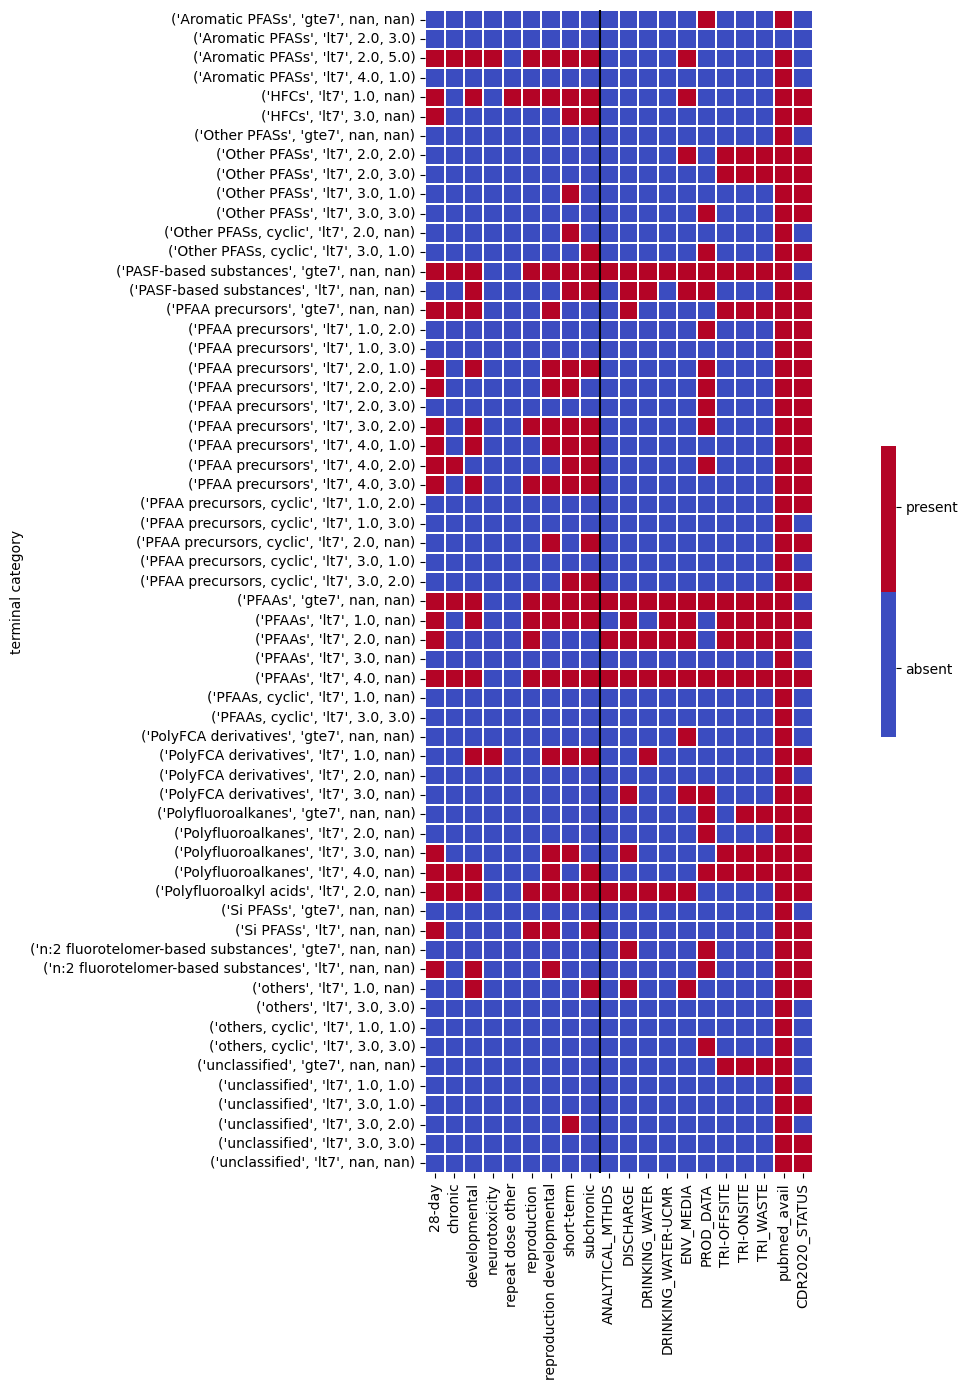

In [214]:
import matplotlib as mpl
f, ax = plt.subplots(figsize=(14, 14))
#labels = X2.index

my_colors=["blue", "red"]
cmap = mpl.cm.get_cmap('coolwarm', 2)
#bounds = [1,2]
#f.colorbar(mpl.cm.ScalarMappable(cmap = cmap, norm=mpl.colors.BoundaryNorm(bounds, cmap.N)))
g = sns.heatmap(X2, cmap = cmap, vmin = 0.9, vmax = .2,  cbar_kws={"shrink": 0.25}, square = True,xticklabels='auto', yticklabels='auto', linewidths = 0.3, ax = ax)

colorbar = ax.collections[0].colorbar
#print(colorbar)
M=X2.max().max()
#print(M)
colorbar.set_ticks([0.35*M,0.75*M])
colorbar.set_ticklabels(['absent','present'])
#colorbar.ax.set_aspect(0.15)


#g.set_yticks(np.arange(len(X2.index)))
#g.set_yticklabels([''] +labels, fontsize = 8)
g.set_ylabel('terminal category')
#g.set_yticks(range(len(X1))
#g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 8)
ax.vlines([9], *ax.get_ylim(), color = 'k')
plt.tight_layout()
f.savefig(figures_dir+'Figure15_130524.png', dpi = 300);